In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
from IPython import display
from lib.viz import showarray

from stable_baselines import SAC
from stable_baselines.common.vec_env import VecNormalize
from stable_baselines.common.cmd_util import make_vec_env

import os, time, json, io
os.environ["MLFLOW_TRACKING_URI"] = "sqlite:///mlruns/db.sqlite"
import mlflow
mlflow_client = mlflow.tracking.MlflowClient()

from lib import eos
from lib.eos import EyeOnStickEnv
from lib.run import run_env_nsteps

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



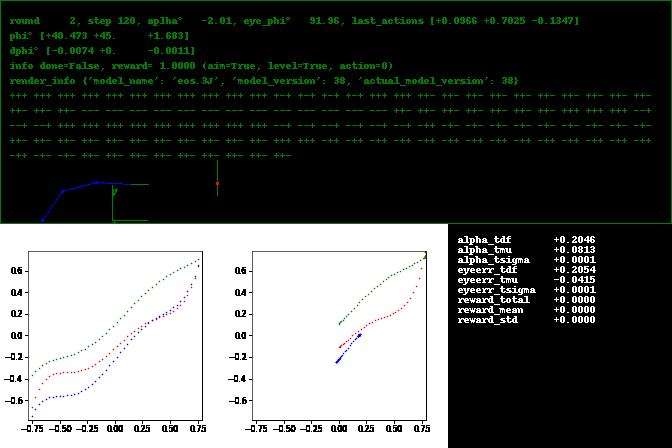

In [ ]:
NJ = 3
model_name, model_version = f"eos.{NJ}J", 38
model, model_source = None, None

params = {'GEAR_FUNC_NOISE': 15}

lastrun_metrics = {}
lastrun_trajs = None
lastrun_gearfuncs = None

while True:
    if model_version is not None:
        registered_model = mlflow_client.get_model_version(model_name, model_version)
    else:
        registered_model = mlflow_client.get_latest_versions(model_name, stages=["None"])[0]
        
    #if model_source is None or model_source != registered_model.source:
    model_source = registered_model.source
    actual_model_version = registered_model.version
    model = SAC.load(model_source)
    
    params_fname = f'{model_source}.json'
    with open(params_fname, 'r') as fp:
        loaded_params = json.load(fp)
        
    params = {**loaded_params, **params} # merge, overriding loaded params 
        
    env = make_vec_env(lambda: EyeOnStickEnv(NJ, params), n_envs=1)
    model.set_env(env)
    env.env_method('set_render_info', {'model_name': model_name, 'model_version': model_version, 'actual_model_version': actual_model_version})

    def get_metrics_dashboard(metrics):
        dashboard_img = Image.new('RGB', (224, 224))
        dashboard_draw = ImageDraw.Draw(dashboard_img)
        
        def draw_text(txt, vpos=0):
            vpos += 1
            dashboard_draw.text((10, 10*vpos), txt)
            return vpos

        # draw metrics
        vpos = 0
        for key, val in metrics.items():
            vpos = draw_text(f'{key:15s} {val:+.4f}', vpos=vpos)
        
        return np.asarray(dashboard_img)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=224/4)
    colors="rgb"
    
    def get_env_dashboard(gearfuncs):
        if gearfuncs is None:
            return np.zeros((224, 224, 3))

        ax.cla()
        ax.set_xlim([-eos.PHI_AMP, eos.PHI_AMP])
        ax.set_ylim([-eos.PHI_AMP, eos.PHI_AMP])
    
        gfx = np.linspace(-eos.PHI_AMP, eos.PHI_AMP, 50)
        for i, gf in enumerate(gearfuncs):
            gfy = gf(gfx)
            ax.scatter(gfx, gfy, 1, colors[i])
        
        io_buf = io.BytesIO()
        fig.savefig(io_buf, format='raw')
        io_buf.seek(0)
        img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                             newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
        io_buf.close()

        return img_arr[:,:,[0,1,2]] # take only RGB from RGBA
        
    def get_env_dashboard2(trajs):
        if trajs is None:
            return np.zeros((224, 224, 3))

        ax.cla()
        ax.set_xlim([-eos.PHI_AMP, eos.PHI_AMP])
        ax.set_ylim([-eos.PHI_AMP, eos.PHI_AMP])
        for i in range(trajs.shape[2]):
            ax.scatter(trajs[:,0,i], trajs[:,1,i], 1, colors[i])

        io_buf = io.BytesIO()
        fig.savefig(io_buf, format='raw')
        io_buf.seek(0)
        img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                             newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
        io_buf.close()

        return img_arr[:,:,[0,1,2]] # take only RGB from RGBA
        
#    def get_blank_dashboard():
#        dashboard_img = Image.new('RGB', (224, 224))
#        dashboard_draw = ImageDraw.Draw(dashboard_img)
#        return np.asarray(dashboard_img)

    def get_dashboard():
        return np.hstack((
            get_env_dashboard(lastrun_gearfuncs),
            get_env_dashboard2(lastrun_trajs),
            get_metrics_dashboard(lastrun_metrics)
        ))
            
    dashboard_img_array = get_dashboard()
    
    def displayfunc(img_array):
        display.clear_output(wait=True)
        img_array = np.vstack((img_array, dashboard_img_array))
        showarray(img_array)
        time.sleep(0.05)
    
    lastrun_trajs = None
    def trajfunc(traj): # (2, NJ) where 2 corresponds to phi and _phi
        global lastrun_trajs
        traj = traj[np.newaxis,:,:] # make it (1, 2, NJ)
        if lastrun_trajs is None:
            lastrun_trajs = traj
        else:
            lastrun_trajs = np.vstack((lastrun_trajs, traj))
        # (?, 2, NJ)

    lastrun_metrics, data = run_env_nsteps(env, model, params['MAX_NSTEPS'], displayfunc=displayfunc, trajfunc=trajfunc)
    lastrun_gearfuncs = list(env.envs[0].gearfuncs)